# CS585 Assignment 2 Programming Part
### Author: Jiangshan Luo
### Uni ID: U89971259

### <span style="color:blue;"> In this notebook, I will present the method for my Python program to handle each single task in the HW2 requirement by processing an image individually and show the result for each stage.</span> 
### <span style="color:blue;"> The real program (process all images) is shown in the last cell which is only the merged version of the cells above. </span> 

In [60]:
import numpy as np
import cv2
from os import listdir, makedirs
from os.path import isfile, join, abspath, exists
from collections import Counter
from IPython.display import Image as print_image
import math

In [61]:
# read data
data_path = abspath('./shapes_dataset/shapes_train2018')
data_list = [join(data_path, file) for file in listdir(data_path) if isfile(join(data_path, file)) and 'jpeg' in file]
annotation_path = abspath('./shapes_dataset/annotations')
annotation_list = [join(annotation_path, file) for file in listdir(annotation_path) if isfile(join(annotation_path, file)) and 'png' in file]

In [62]:
test_case = 1027
output_file = './output/' + str(test_case)
if not exists(output_file):
    makedirs(output_file)

## 1. Determine the background

The background color is 217


e:\Users\ljsPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in ubyte_scalars


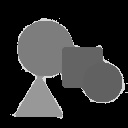

In [63]:
img = cv2.imread(data_list[test_case - 1000])

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# medianBlur -> remove the noise
img_gray = cv2.medianBlur(img_gray,5)

# find the background color
boarder_pixel = []
for x in range(img_gray.shape[0]):
    for y in range(img_gray.shape[1]):
        if x == 0 or y == 0:
            boarder_pixel.append(img_gray[x][y])
            
# assume background color is the pixel value that has the maxi|mum frequency
background_color, frequency = Counter(boarder_pixel).most_common(1)[0]
print('The background color is', background_color)

img_withoutBG = img_gray.copy()
for x in range(img_withoutBG.shape[0]):
    for y in range(img_withoutBG.shape[1]):
        if(np.abs(img_withoutBG[x][y] - background_color)) < 10:
            img_withoutBG[x][y] = 0
            '''# Floodfill
            h, w = img_gray.shape[:2]
            mask = np.zeros((h + 2, w + 2), np.uint8)
            cv2.floodFill(img_gray, mask, (x, y), 0)
            cv2.imwrite(str(count)+'.jpeg',img_gray)
            count = count + 1'''
     
cv2.imwrite(output_file + '/img_withoutBG.jpeg',img_withoutBG)
print_image(output_file + '/img_withoutBG.jpeg')

## 2. Label every shape blob based on color
### <span style="color:blue;">2.1 remove the noises <span/>

In [64]:
''' 
bfs(img, flag_img, seed_point=[0,0])

    use BFS to find the size of each blob
    input: 
        - img: src image
        - flag_img: boolean map used to mark the blob
        - seed_point: start searching point
    output:
        - count: size of the blob
'''
def bfs(img, flag_img, seed_point=[0,0]):
    count = 1
    matrix = [[1,0],[-1,0],[0,1],[0,-1]]
    neighbor = [0,0]
    flag_img[seed_point[0]][seed_point[1]] = 1
    
    queue = [seed_point]
    
    while len(queue) > 0:
        # enqueue and dequeue
        current_point = queue[0]
        del queue[0]
        
        for element in matrix:
            neighbor[0] = current_point[0] + element[0]
            neighbor[1] = current_point[1] + element[1]
            if neighbor[0] >= 0 and neighbor[1] >=0 and neighbor[0] < img.shape[0] and neighbor[1] < img.shape[1]:
                if np.abs(img[neighbor[0]][neighbor[1]] - img[seed_point[0]][seed_point[1]]) < 3 and flag_img[neighbor[0]][neighbor[1]] == 0:
                    count = count + 1
                    flag_img[neighbor[0]][neighbor[1]] = 1
                    img[neighbor[0]][neighbor[1]] = img[seed_point[0]][seed_point[1]]
                    queue.append(neighbor.copy())
    
    return count

'''# test bfs
flag = np.zeros_like(img_withoutBG)
bfs(img_withoutBG, flag)'''

'''
remove_surrounding_noise(img, blob_color = [])

    remove noise with colors other than blobs and small size blobs
    input:
        - img: src image
        - blob_color: the colors of the blobs
'''
def remove_surrounding_noise(img, blob_color = []):
    search_map = np.zeros_like(img)
    
    # remove noise with the blob colors
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if img[x][y] in blob_color:
                if search_map[x][y] == 0:
                    # find the size of the image
                    flag_map = np.zeros_like(img)
                    blob_size = bfs(img, flag_map, [x,y])

                    # update the search map
                    search_map += flag_map

                    # remove the blobs which size < 300 pixels
                    if blob_size < 300:
                        for x_1 in range(flag_map.shape[0]):
                            for y_1 in range(flag_map.shape[1]):
                                if(flag_map[x_1][y_1] == 1):
                                    img[x_1][y_1] = 0
            # remove noise with colors other than blobs
            else:
                img[x][y] = 0

'''# test remove_surrounding_noise
test_img = img_noNoise.copy()
remove_surrounding_noise(test_img, blob_colors)
cv2.imwrite('2.jpeg',test_img)

blob_detector=[]
for x in range(test_img.shape[0]):
    for y in range(test_img.shape[1]):
        if(test_img[x][y] != 0):
            blob_detector.append(test_img[x][y])
Counter(blob_detector)'''

"# test remove_surrounding_noise\ntest_img = img_noNoise.copy()\nremove_surrounding_noise(test_img, blob_colors)\ncv2.imwrite('2.jpeg',test_img)\n\nblob_detector=[]\nfor x in range(test_img.shape[0]):\n    for y in range(test_img.shape[1]):\n        if(test_img[x][y] != 0):\n            blob_detector.append(test_img[x][y])\nCounter(blob_detector)"

### <span style="color:blue;">2.2 label blobs <span/>
every unique grayscale color value remain in the image represent a blob

e:\Users\ljsPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in ubyte_scalars


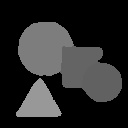

In [65]:
blob_detector = []
for x in range(img_withoutBG.shape[0]):
    for y in range(img_withoutBG.shape[1]):
        if(img_withoutBG[x][y] != 0):
            blob_detector.append(img_withoutBG[x][y])

# assume blobs have more than 500 pixels
counter_keys = list(Counter(blob_detector).keys())
blob_colors = [x for x in counter_keys if Counter(blob_detector)[x] > 300]

img_noNoise = img_withoutBG.copy()

# remove the noise (non-blobs-color pixels and small size blobs)
remove_surrounding_noise(img_noNoise, blob_colors)

# medianBlur -> remove the noise
img_noNoise = cv2.medianBlur(img_noNoise,5)

'''#recognize the shapes
for x in range(img_noNoise.shape[0]):
    for y in range(img_noNoise.shape[1]):
        if(img_noNoise[x][y] in blob_colors):
            img_noNoise[x][y] = 255'''

obj_num = 1
for color in blob_colors:
    blob_image = np.zeros_like(img_noNoise)
    for x in range(img_noNoise.shape[0]):
        for y in range(img_noNoise.shape[1]):
            if img_noNoise[x][y] == color:
                blob_image[x][y] = 255
    cv2.imwrite(output_file + '/blob_' + str(obj_num) + '.jpeg', blob_image)
    obj_num += 1

cv2.imwrite(output_file + '/img_noNoise.jpeg',img_noNoise)
print_image(output_file + '/img_noNoise.jpeg')

## 3. Implement the boundary following algorithm

In [66]:
'''
boundary_following(img, blob_color)
    
    implementation of the boundary following algorithm
    input: 
        - img: src image
        - blob_color: the colors of the blobs
    output:
        - contour_map: a list of contour images
'''
def boundary_following(img, blob_color):
    contour_map = []
    search_map = np.zeros_like(img)
    # clockwise start from the west
    clockwise_matrix = [[0,-1],[-1,-1],[-1,0],[-1,1],[0,1],[1,1],[1,0],[1,-1]]
    # boundary pixel outside R
    b = [0,0]
    # current pixel inside object on boundary
    c = [0,0]
    
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            # find the start pixel
            if img[x][y] in blob_color and search_map[x][y] == 0 and bfs(img, search_map, [x,y]) > 300:
                # use bfs() to update the search_map -> make sure every blob only be computed once
                pixel_color = img[x][y]
                
                contour = np.zeros_like(img)
                c = [x,y]
                b[0] = c[0] + clockwise_matrix[0][0]
                b[1] = c[1] + clockwise_matrix[0][1]
                
                finish_flag = False
                while not finish_flag:
                    # find next neighbor (b is supposed to start from the west neighbor outside R)
                    neighbor = b.copy()
                    start_index = clockwise_matrix.index([neighbor[0] - c[0], neighbor[1] - c[1]])
                    
                    for loop_time in range(8):
                        neighbor[0] = c[0] + clockwise_matrix[(start_index + loop_time) % 8][0]
                        neighbor[1] = c[1] + clockwise_matrix[(start_index + loop_time) % 8][1]
                        
                        # find the first neighbor inside R, update b and c
                        if neighbor[0] >= 0 and neighbor[1] >=0 and neighbor[0] < img.shape[0] and neighbor[1] < img.shape[1] \
                        and img[neighbor[0]][neighbor[1]] == pixel_color:
                                c = neighbor.copy()
                                b = last_neighbor.copy()
                                contour[neighbor[0]][neighbor[1]] = 255
                                
                                # finish
                                if neighbor == [x,y]:
                                    finish_flag = True
                                
                                break
                        else:
                            last_neighbor = neighbor.copy()
                
                contour_map.append(contour.copy())
    
    return np.array(contour_map)

'''# test boundary_following
test_contour = boundary_following(img_noNoise, blob_colors)
cv2.imwrite('3.jpeg', test_contour[0])'''

"# test boundary_following\ntest_contour = boundary_following(img_noNoise, blob_colors)\ncv2.imwrite('3.jpeg', test_contour[0])"

e:\Users\ljsPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in ubyte_scalars


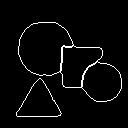

In [67]:
contours = boundary_following(img_noNoise, blob_colors)

merged_contour = np.zeros_like(img_noNoise)
for contour in contours:
    merged_contour += contour

cv2.imwrite(output_file + '/boundary_following.jpeg', merged_contour)
print_image(output_file + '/boundary_following.jpeg')

## 4. Compare the boundary following algorithm with cv2.findContours

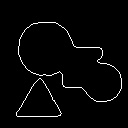

In [68]:
_, contours_opencv, hierarchy = cv2.findContours(img_noNoise, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

image_background = np.zeros_like(img_noNoise)
# contourIdx=-1 draw all contours
opencv_drawContours_result = cv2.drawContours(image_background, contours_opencv, contourIdx=-1, color=255, thickness=1)

cv2.imwrite(output_file + '/opencv_drawContours_result.jpeg',opencv_drawContours_result)
print_image(output_file + '/opencv_drawContours_result.jpeg')

## 5. Classify boundary pixels (background/another blob/image boundary)
use the contours and blob colors gained previously to classify the boundary pixel:

    - against background: have background neighbor pixel
    - against image boundary: image boundary pixel
    - against another blob: have neighbor pixel that belongs to one of the other blob

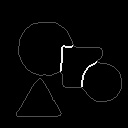

In [69]:
# mark three categories with grayscale value: 80, 160, 240
classified_contours = []
N4_neighbor = [[-1,0],[1,0],[0,-1],[0,1]]
neighbor = [0,0]

for contour in contours:
    classified_contour = contour.copy()
    
    for x in range(classified_contour.shape[0]):
        for y in range(classified_contour.shape[1]):
            # classify each pixel in the contour
            if classified_contour[x][y] == 255:
                is_background = False
                is_boundary = False
                
                # find the characteristics of its neighbors
                for element in N4_neighbor:
                    neighbor[0] = x + element[0]
                    neighbor[1] = y + element[1]
                    
                    # iamge boundary
                    if not (neighbor[0] >= 0 and neighbor[1] >=0 and neighbor[0] < img.shape[0] and neighbor[1] < img.shape[1]):
                        is_boundary = True
                        break
                    # background
                    elif img_noNoise[neighbor[0]][neighbor[1]] == 0:
                        is_background = True
                        break
                
                if(is_background):
                    classified_contour[x][y] = 80
                elif(is_boundary):
                    classified_contour[x][y] = 160
                # others belongs to contour against other blobs
                else:
                    classified_contour[x][y] = 240

    classified_contours.append(classified_contour)

# classified_contours contains classification info of each contour
merged_classified_contour = np.zeros_like(img_noNoise)
for contour in classified_contours:
    merged_classified_contour += contour
    
cv2.imwrite(output_file + '/merged_classified_contour.jpeg',merged_classified_contour)
print_image(output_file + '/merged_classified_contour.jpeg')

## 5. Blob shape recognition

use different attributes of the blobs to recognize their shape. For this task, part of the blob contours will be used (those against the background) because they are not influenced by other factors and are the original shape of the blobs

### centorids and compactness

In [70]:
# find centorids of blobs in order to determine the positions of them in the annotation file
centorids = []
compactness = []

for contour in classified_contours:
    sum_contour = [0,0]
    pixel_count = 0
    blob_area = 0
    compute_area= False
    
    for x in range(contour.shape[0]):
        for y in range(contour.shape[1]):
            if contour[x][y] != 0:
                sum_contour[0] += x
                sum_contour[1] += y
                pixel_count += 1
                
                if not compute_area:
                    blob_area = bfs(img_noNoise, np.zeros_like(img_noNoise), [x,y])
                    compute_area = True
    
    centorids.append([sum_contour[0] / pixel_count, sum_contour[1] / pixel_count])
    compactness.append(pixel_count ** 2 / blob_area)

print(centorids)
print(compactness)

e:\Users\ljsPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in ubyte_scalars


[[47.668711656441715, 44.79141104294479], [63.63768115942029, 77.41304347826087], [81.78378378378379, 101.72072072072072], [103.5, 38.65]]
[12.126426289365586, 15.674074074074074, 9.809713375796179, 13.81957773512476]


### approxPolyDP guess the shape

In [71]:
# ordered contour
original_contours = classified_contours.copy()
for index in range(len(original_contours)):
    for x in range(original_contours[index].shape[0]):
        for y in range(original_contours[index].shape[1]):
            if original_contours[index][x][y] != 80:
                original_contours[index][x][y] = 0

shapes = []
for contour in original_contours:
    shape = 0
    _, contours_opencv, hierarchy = cv2.findContours(contour, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt_piece in contours_opencv:
        shape += len(cv2.approxPolyDP(np.array(cnt_piece), 10, closed=False))
    
    shapes.append(shape)
    
shapes

[9, 7, 7, 8]

### matchShapes compute the similarity

In [72]:
shape_match = []
square_sample = np.array([[0,0],[0,1],[0,2],[0,3],[0,4],[0,5],\
                          [1,5],[2,5],[3,5],[4,5],[5,5],\
                          [5,4],[5,3],[5,2],[5,1],[5,0],\
                          [4,0],[3,0],[2,0],[1,0],[0,0]])
triangle_sample = np.array([[0,0],[1,np.sqrt(3)],[2,2*np.sqrt(3)],[3,3*np.sqrt(3)],\
                            [4,2*np.sqrt(3)],[5,np.sqrt(3)],[6,0],\
                            [5,0],[4,0],[3,0],[2,0],[1,0],[0,0]])

for contour in original_contours:
    _, contours_opencv, hierarchy = cv2.findContours(contour, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    max_piece_index = np.argmax([len(x) for x in contours_opencv])
    
    square_match = cv2.matchShapes(contours_opencv[max_piece_index], square_sample, 1, 0)
    triangle_match = cv2.matchShapes(contours_opencv[max_piece_index], triangle_sample, 1, 0)
    
    shape_match.append([square_match, triangle_match])

shape_match

[[1.7976931348623157e+308, 1.7976931348623157e+308],
 [0.24579814122406218, 1.032730140758746],
 [1.7976931348623157e+308, 1.7976931348623157e+308],
 [0.08743825494881086, 0.6808244608241718]]

### Conclusion of the recognition

In [80]:
clssified_blobs = []
for blob_index in range(len(contours)):
    # considered to be circule
    if shapes[blob_index] > 10 or (shape_match[blob_index][0] > 10 and shape_match[blob_index][1] > 10):
        clssified_blobs.append('circle')
    # considered to be triangle
    elif (shape_match[blob_index][1] < 2 and shape_match[blob_index][0] * 3 < shape_match[blob_index][1]) or (shapes[blob_index] >= 6 and shape_match[blob_index][0] > 10 and shape_match[blob_index][1] > 10):
        clssified_blobs.append('triangle')
    # considered to be square
    else:
        clssified_blobs.append('square')

clssified_blobs

['circle', 'triangle', 'circle', 'circle']

## 6. Evaluation

In [81]:
relevant_annotations = [x for x in annotation_list if str(test_case) in x and 'crowd' not in x]

evaluation = {'triangle_total': 0, 'triangle_true_predict': 0,\
              'square_total': 0, 'square_true_predict': 0,\
              'circle_total': 0, 'circle_true_predict': 0}

for file in relevant_annotations:
    if 'triangle' in file:
        evaluation['triangle_total'] += 1
    elif 'square' in file:
        evaluation['square_total'] += 1
    elif 'circle' in file:
        evaluation['circle_total'] += 1
    
    matched_index = -1
    verify_img = cv2.imread(file)
    verify_img = cv2.cvtColor(verify_img, cv2.COLOR_BGR2GRAY)
    for contour_index in range(len(original_contours)):
        if matched_index != -1:
            break
        for x in range(original_contours[contour_index].shape[0]):
            for y in range(original_contours[contour_index].shape[1]):
                if original_contours[contour_index][x][y] != 0 and verify_img[x][y] != 0:
                    matched_index = contour_index
                    break
    
    if clssified_blobs[matched_index] in file:
        evaluation[clssified_blobs[matched_index] + '_true_predict'] += 1

evaluation

{'circle_total': 1,
 'circle_true_predict': 1,
 'square_total': 1,
 'square_true_predict': 0,
 'triangle_total': 1,
 'triangle_true_predict': 0}

In [82]:
precision = (evaluation['triangle_true_predict'] + evaluation['square_true_predict'] + evaluation['circle_true_predict']) / \
            (evaluation['triangle_total'] + evaluation['square_total'] + evaluation['circle_total'])

print('precision:', np.ceil(precision * 100), '%')

precision: 34.0 %


In [83]:
txt_file = open(output_file + '/Evaluation.txt','w')
txt_file.write(str(evaluation))
txt_file.write('\n')
txt_file.write('precision:' + str(np.ceil(precision * 100)) + '%')
txt_file.close()

# Process all images (merge the code above)

In [87]:
overall_evaluation = {'triangle_total': 0, 'triangle_true_predict': 0,\
                  'square_total': 0, 'square_true_predict': 0,\
                  'circle_total': 0, 'circle_true_predict': 0}

for case in range(len(data_list)):
    case += 1000
    output_file = './output/' + str(case)
    if not exists(output_file):
        makedirs(output_file)

    img = cv2.imread(data_list[case - 1000])

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # medianBlur -> remove the noise
    img_gray = cv2.medianBlur(img_gray,5)

    # find the background color
    boarder_pixel = []
    for x in range(img_gray.shape[0]):
        for y in range(img_gray.shape[1]):
            if x == 0 or y == 0:
                boarder_pixel.append(img_gray[x][y])

    # assume background color is the pixel value that has the maxi|mum frequency
    background_color, frequency = Counter(boarder_pixel).most_common(1)[0]
    print('The background color is', background_color)

    img_withoutBG = img_gray.copy()
    for x in range(img_withoutBG.shape[0]):
        for y in range(img_withoutBG.shape[1]):
            if(img_withoutBG[x][y] == background_color):
                img_withoutBG[x][y] = 0
                '''# Floodfill
                h, w = img_gray.shape[:2]
                mask = np.zeros((h + 2, w + 2), np.uint8)
                cv2.floodFill(img_gray, mask, (x, y), 0)
                cv2.imwrite(str(count)+'.jpeg',img_gray)
                count = count + 1'''

    cv2.imwrite(output_file + '/img_withoutBG.jpeg',img_withoutBG)
    print_image(output_file + '/img_withoutBG.jpeg')

    blob_detector = []
    for x in range(img_withoutBG.shape[0]):
        for y in range(img_withoutBG.shape[1]):
            if(img_withoutBG[x][y] != 0):
                blob_detector.append(img_withoutBG[x][y])

    # assume blobs have more than 500 pixels
    counter_keys = list(Counter(blob_detector).keys())
    blob_colors = [x for x in counter_keys if Counter(blob_detector)[x] > 300]

    img_noNoise = img_withoutBG.copy()

    # remove the noise (non-blobs-color pixels and small size blobs)
    remove_surrounding_noise(img_noNoise, blob_colors)

    # medianBlur -> remove the noise
    img_noNoise = cv2.medianBlur(img_noNoise,5)

    '''#recognize the shapes
    for x in range(img_noNoise.shape[0]):
        for y in range(img_noNoise.shape[1]):
            if(img_noNoise[x][y] in blob_colors):
                img_noNoise[x][y] = 255'''

    cv2.imwrite(output_file + '/img_noNoise.jpeg',img_noNoise)
    print_image(output_file + '/img_noNoise.jpeg')
    
    obj_num = 1
    for color in blob_colors:
        blob_image = np.zeros_like(img_noNoise)
        for x in range(img_noNoise.shape[0]):
            for y in range(img_noNoise.shape[1]):
                if img_noNoise[x][y] == color:
                    blob_image[x][y] = 255
        cv2.imwrite(output_file + '/blob_' + str(obj_num) + '.jpeg', blob_image)
        obj_num += 1

    contours = boundary_following(img_noNoise, blob_colors)

    merged_contour = np.zeros_like(img_noNoise)
    for contour in contours:
        merged_contour += contour

    cv2.imwrite(output_file + '/boundary_following.jpeg', merged_contour)
    print_image(output_file + '/boundary_following.jpeg')

    _, contours_opencv, hierarchy = cv2.findContours(img_noNoise, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    image_background = np.zeros_like(img_noNoise)
    # contourIdx=-1 draw all contours
    opencv_drawContours_result = cv2.drawContours(image_background, contours_opencv, contourIdx=-1, color=255, thickness=1)

    cv2.imwrite(output_file + '/opencv_drawContours_result.jpeg',opencv_drawContours_result)
    print_image(output_file + '/opencv_drawContours_result.jpeg')

    # mark three categories with grayscale value: 80, 160, 240
    classified_contours = []
    N4_neighbor = [[-1,0],[1,0],[0,-1],[0,1]]
    neighbor = [0,0]

    for contour in contours:
        classified_contour = contour.copy()

        for x in range(classified_contour.shape[0]):
            for y in range(classified_contour.shape[1]):
                # classify each pixel in the contour
                if classified_contour[x][y] == 255:
                    is_background = False
                    is_boundary = False

                    # find the characteristics of its neighbors
                    for element in N4_neighbor:
                        neighbor[0] = x + element[0]
                        neighbor[1] = y + element[1]

                        # iamge boundary
                        if not (neighbor[0] >= 0 and neighbor[1] >=0 and neighbor[0] < img.shape[0] and neighbor[1] < img.shape[1]):
                            is_boundary = True
                            break
                        # background
                        elif img_noNoise[neighbor[0]][neighbor[1]] == 0:
                            is_background = True
                            break

                    if(is_background):
                        classified_contour[x][y] = 80
                    elif(is_boundary):
                        classified_contour[x][y] = 160
                    # others belongs to contour against other blobs
                    else:
                        classified_contour[x][y] = 240

        classified_contours.append(classified_contour)

    # classified_contours contains classification info of each contour
    merged_classified_contour = np.zeros_like(img_noNoise)
    for contour in classified_contours:
        merged_classified_contour += contour

    cv2.imwrite(output_file + '/merged_classified_contour.jpeg',merged_classified_contour)
    print_image(output_file + '/merged_classified_contour.jpeg')

    # find centorids of blobs in order to determine the positions of them in the annotation file
    centorids = []
    compactness = []

    for contour in classified_contours:
        sum_contour = [0,0]
        pixel_count = 0
        blob_area = 0
        compute_area= False

        for x in range(contour.shape[0]):
            for y in range(contour.shape[1]):
                if contour[x][y] != 0:
                    sum_contour[0] += x
                    sum_contour[1] += y
                    pixel_count += 1

                    if not compute_area:
                        blob_area = bfs(img_noNoise, np.zeros_like(img_noNoise), [x,y])
                        compute_area = True

        centorids.append([sum_contour[0] / pixel_count, sum_contour[1] / pixel_count])
        compactness.append(pixel_count ** 2 / blob_area)

    print(centorids)
    print(compactness)

    # ordered contour
    original_contours = classified_contours.copy()
    for index in range(len(original_contours)):
        for x in range(original_contours[index].shape[0]):
            for y in range(original_contours[index].shape[1]):
                if original_contours[index][x][y] != 80:
                    original_contours[index][x][y] = 0

    shapes = []
    for contour in original_contours:
        shape = 0
        _, contours_opencv, hierarchy = cv2.findContours(contour, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for cnt_piece in contours_opencv:
            shape += len(cv2.approxPolyDP(np.array(cnt_piece), 10, closed=False))

        shapes.append(shape)

    shapes

    shape_match = []
    square_sample = np.array([[0,0],[0,1],[0,2],[0,3],[0,4],[0,5],\
                              [1,5],[2,5],[3,5],[4,5],[5,5],\
                              [5,4],[5,3],[5,2],[5,1],[5,0],\
                              [4,0],[3,0],[2,0],[1,0],[0,0]])
    triangle_sample = np.array([[0,0],[1,np.sqrt(3)],[2,2*np.sqrt(3)],[3,3*np.sqrt(3)],\
                                [4,2*np.sqrt(3)],[5,np.sqrt(3)],[6,0],\
                                [5,0],[4,0],[3,0],[2,0],[1,0],[0,0]])

    for contour in original_contours:
        _, contours_opencv, hierarchy = cv2.findContours(contour, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        max_piece_index = np.argmax([len(x) for x in contours_opencv])

        square_match = cv2.matchShapes(contours_opencv[max_piece_index], square_sample, 1, 0)
        triangle_match = cv2.matchShapes(contours_opencv[max_piece_index], triangle_sample, 1, 0)

        shape_match.append([square_match, triangle_match])

    shape_match

    clssified_blobs = []
    for blob_index in range(len(contours)):
        # considered to be circule
        if shapes[blob_index] > 10 or (shapes[blob_index] >= 10 and shape_match[blob_index][0] > 10 and shape_match[blob_index][1] > 10):
            clssified_blobs.append('circle')
        # considered to be triangle
        elif (shape_match[blob_index][1] < 2 and shape_match[blob_index][0] * 3 < shape_match[blob_index][1]) or (shapes[blob_index] >= 6 and shape_match[blob_index][0] > 10 and shape_match[blob_index][1] > 10):
            clssified_blobs.append('triangle')
        # considered to be square
        else:
            clssified_blobs.append('square')

    for index in range(len(clssified_blobs)):
        print('blob ' + str(index + 1) + 'is' + clssified_blobs[index])

    relevant_annotations = [x for x in annotation_list if str(case) in x]

    evaluation = {'triangle_total': 0, 'triangle_true_predict': 0,\
                  'square_total': 0, 'square_true_predict': 0,\
                  'circle_total': 0, 'circle_true_predict': 0}

    for file in relevant_annotations:
        if 'triangle' in file:
            evaluation['triangle_total'] += 1
        elif 'square' in file:
            evaluation['square_total'] += 1
        elif 'circle' in file:
            evaluation['circle_total'] += 1

        matched_index = -1
        verify_img = cv2.imread(file)
        verify_img = cv2.cvtColor(verify_img, cv2.COLOR_BGR2GRAY)
        for contour_index in range(len(original_contours)):
            if matched_index != -1:
                break
            for x in range(original_contours[contour_index].shape[0]):
                for y in range(original_contours[contour_index].shape[1]):
                    if original_contours[contour_index][x][y] != 0 and verify_img[x][y] != 0:
                        matched_index = contour_index
                        break

        if clssified_blobs[matched_index] in file:
            evaluation[clssified_blobs[matched_index] + '_true_predict'] += 1

    evaluation

    precision = (evaluation['triangle_true_predict'] + evaluation['square_true_predict'] + evaluation['circle_true_predict']) / \
                (evaluation['triangle_total'] + evaluation['square_total'] + evaluation['circle_total'])

    print('precision:', np.ceil(precision * 100), '%')

    txt_file = open(output_file + '/Evaluation.txt','w')
    txt_file.write(str(evaluation))
    txt_file.write('\n')
    txt_file.write('precision:' + str(np.ceil(precision * 100)) + '%')
    txt_file.close()
    
    for key in overall_evaluation.keys():
        overall_evaluation[key] += evaluation[key]

precision = (overall_evaluation['triangle_true_predict'] + overall_evaluation['square_true_predict'] + overall_evaluation['circle_true_predict']) / \
                (overall_evaluation['triangle_total'] + overall_evaluation['square_total'] + overall_evaluation['circle_total'])

txt_file = open('./output/Overall_Evaluation.txt','w')
txt_file.write(str(overall_evaluation))
txt_file.write('\n')
txt_file.write('precision:' + str(np.ceil(precision * 100)) + '%')
txt_file.close()

The background color is 178


e:\Users\ljsPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in ubyte_scalars


[[35.004347826086956, 90.25652173913043]]
[14.308899107384367]
blob 1istriangle
precision: 0.0 %
The background color is 139
[[27.146198830409357, 77.18128654970761], [33.94244604316547, 34.03597122302158], [85.5618556701031, 23.5], [99.26388888888889, 100.75]]
[10.959895052473763, 11.7739183424741, 14.893549663632767, 15.18255776114546]
blob 1iscircle
blob 2istriangle
blob 3istriangle
blob 4istriangle
precision: 25.0 %
The background color is 40
[[43.1025641025641, 10.158974358974358], [20.44859813084112, 26.57943925233645], [55.831932773109244, 33.6890756302521], [78.91333333333333, 52.32666666666667], [103.92361111111111, 30.9375]]
[62.4384236453202, 12.271168274383708, 10.366764275256223, 54.74452554744526, 13.74155069582505]
blob 1iscircle
blob 2istriangle
blob 3istriangle
blob 4issquare
blob 5iscircle
precision: 67.0 %
The background color is 86
[[49.119565217391305, 40.16847826086956], [96.4493670886076, 26.9873417721519]]
[15.659574468085106, 15.880407124681934]
blob 1iscircle


[[86.71875, 98.175]]
[14.806246385193754]
blob 1istriangle
precision: 100.0 %
The background color is 65
[[33.298780487804876, 39.5]]
[13.799897383273473]
blob 1istriangle
precision: 0.0 %
The background color is 34
[[67.26470588235294, 89.96470588235294], [81.77551020408163, 49.945578231292515]]
[14.118221787982414, 16.520642201834864]
blob 1iscircle
blob 2istriangle
precision: 50.0 %
The background color is 193
[[44.642857142857146, 50.357142857142854]]
[14.264150943396226]
blob 1istriangle
precision: 100.0 %
The background color is 144
[[27.97163120567376, 31.18439716312057], [69.63846153846154, 35.58461538461538], [107.88785046728972, 45.57943925233645]]
[10.575, 11.319490957803081, 11.611561866125761]
blob 1iscircle
blob 2iscircle
blob 3istriangle
precision: 67.0 %
The background color is 161
[[97.1523178807947, 61.12582781456954]]
[13.768719806763285]
blob 1istriangle
precision: 0.0 %
The background color is 86
[[46.0, 85.0]]
[14.585971131932135]
blob 1istriangle
precision: 0.0 %

KeyboardInterrupt: 